# Algoritmo Random Forest
## Explicación del algoritmo
Adriana Sofía Rozo Cepeda - 202211498

Random Forest es un algoritmo de aprendizaje supervisado basado en la combinación de múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste. Estos árboles son entrenados con diferentes subconjuntos aleatorios de los datos y características, generados mediante *bootstrap* y *bagging* (agregación de modelos).

Cada árbol emite una predicción y, en el caso de problemas de clasificación, se toma la clase con más votos (mayoría), mientras que en problemas de regresión se calcula el promedio de las predicciones de los árboles.

El plus que otorga este modelo es que esa aleatorización en la selección de muestras y características contribuye a disminuir la varianza del este y mejorar su generalización.

En la siguiente imagen se ilustra lo dicho anteriormente

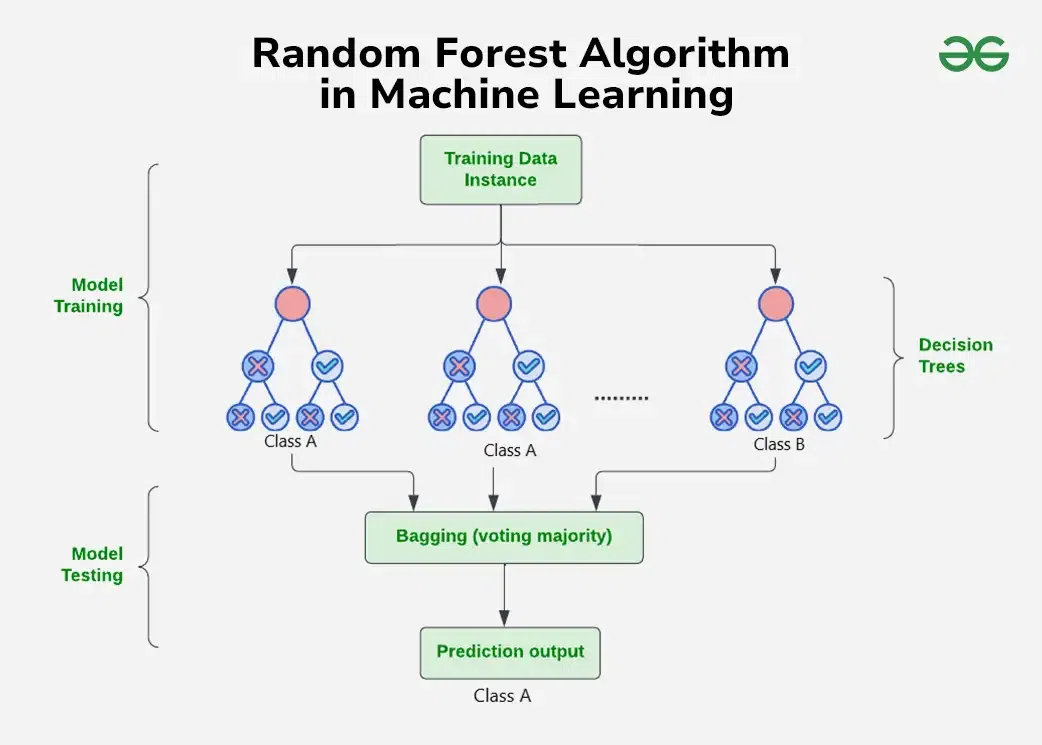

# Instalación de librerías necesarias

In [ ]:
%%capture
!pip install scikit-optimize
!pip install scikit-learn


In [ ]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Carga de los datos

Acá cargamos el conjunto de datos resultante después de todo el procesamiento. Es claro recordar que trabajaremos con las columnas `titulo-words` y `descripcion-words`.

In [ ]:
df = pd.read_csv('datos-procesados.csv')
df.head()

,ID,Label,Titulo,Descripcion,Fecha,longitud_titulo,longitud_descripcion,titulo-words,descripcion-words
0,ID,0,Sondeos: Feijóo acumula todo el voto de la der...,El hundimiento de la coalición En Común/En Mar...,11/06/2020,106,362,sondeos feijoo acumula voto derecha repetiria ...,hundimiento coalicion comunen marea perderia m...
1,ID,0,Boluarte pide a Coalición Canaria no concurrir...,La formación ultra responde al líder del Inici...,13/03/2019,107,148,boluarte pide coalicion canaria concurrir prov...,formacion ultra responde lider iniciativa vers...
2,ID,0,El Gobierno presentará sólo los PGE de 2021 si...,La ministra de Hacienda sigue condicionando su...,04/03/2020,92,351,gobierno presentara solo pge two thousand and ...,ministra hacienda sigue condicionando presenta...
3,ID,0,Vallejo garantiza 'elecciones en paz' en Venez...,"El expresidente asegura que de lo contrario, n...",10/04/2018,50,215,vallejo garantiza elecciones paz venezuela,expresidente asegura contrario participaria ac...
4,ID,0,Cristina Narbona admite que Catalunya vote 'po...,El presidente del Gobierno tiene por delante u...,03/09/2018,94,334,cristina narbona admite catalunya vote autogob...,presidente gobierno delante agenda politica co...


En esta parte eliminamos las columnas que no nos ofrecerán información importante para la predicción.

In [ ]:
df = df.drop(columns=['ID', 'Titulo', 'Descripcion', 'Fecha', 'longitud_titulo','longitud_descripcion'])

# División conjunto de datos

Como podemos observar, decidimos dividir los datos 70%-30% para entrenamiento y validación correspondientemente.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["titulo-words"] + " " + df["descripcion-words"], df["Label"], test_size=0.3, random_state=1)

# Vectorización

`TfidfVectorizer` es apropiado en este caso porque permite transformar el texto en una representación numérica que resalta la importancia de las palabras clave en cada entrada, minimizando el impacto de términos demasiado frecuentes y poco informativos.

Ahora bien, dado que el conjunto de datos contiene 44272 registros, establecer `max_features=7600` ayuda a reducir la dimensionalidad, seleccionando solo las palabras más relevantes sin perder información significativa y sin añadir ruido.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=7600)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Entrenamiento del modelo
En esta etapa tenemos como objetivo ajustar los hiperparámetros del modelo utilizando un conjunto de datos de entrenamiento para que aprenda las relaciones entre las características y las etiquetas.

Tras sintonizar el valor de `n_estimators` manualmente, pude observar que 600 era el mejor valor ya que permitía reducir la varianza y mejorar la estabilidad del modelo.

A continuación podemos ver que se entrena el clasificador con los datos vectorizados (`X_train, y_train`) y se realizan predicciones sobre el conjunto de prueba (`X_test`).

In [ ]:
# Modelo
rf = RandomForestClassifier(n_estimators=600, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)


# Evaluacion del modelo

En la evaluación del modelo nos enfocamos en medir el rendimiento del modelo utilizando métricas clave como la exactitud, precisión, recall, y F1-score, para identificar errores de clasificación.

Estas métricas nos permiten entender qué tan bien el modelo predice las clases correctas en el conjunto de prueba, además de verificar posibles problemas como el sobreajuste..

### Acuracy

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9172


### Reporte de clasificación

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      6671
           1       0.89      0.95      0.92      6611

    accuracy                           0.92     13282
   macro avg       0.92      0.92      0.92     13282
weighted avg       0.92      0.92      0.92     13282



### Matriz de Confusión

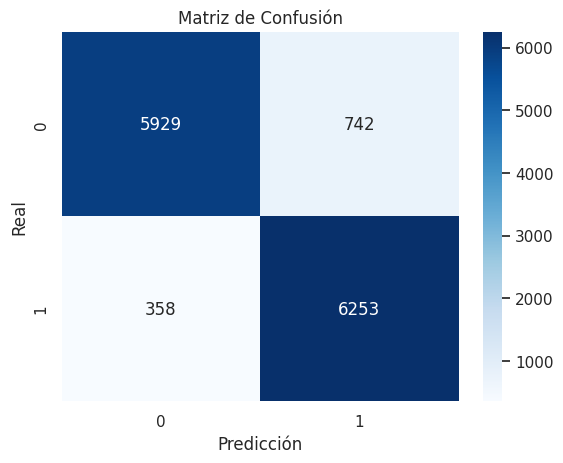

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

El modelo alcanzó una **precisión global del 91.72%**, lo que indica que clasifica correctamente la mayoría de las noticias en el conjunto de prueba. Sin embargo, analizando las métricas en detalle, observamos diferencias en el desempeño entre ambas clases.

En primer lugar, en el **reporte de clasificación**, para las noticias **falsas (clase 0)**, el modelo tiene una **precisión del 94%** y un **recall del 89%**, lo que significa que cuando el modelo predice que una noticia es falsa, tiene una alta probabilidad de estar en lo correcto. Sin embargo, podemos observar que su menor recall indica que aún deja pasar algunas noticias falsas como si fueran verdaderas. Ahora bien, para las noticias **verdaderas (clase 1)**, la precisión es **89%**, mientras que el recall es **95%**, lo que indica que el modelo es más efectivo en detectar noticias verdaderas, aunque ocasionalmente puede clasificarlas erróneamente como falsas.

En segundo lugar, la **matriz de confusión** refuerza esta observación: el modelo clasificó correctamente **5,929 noticias falsas** y **6,253 noticias verdaderas**, pero cometió **742 falsos negativos** (noticias falsas clasificadas erróneamente como verdaderas) y **358 falsos positivos** (noticias verdaderas clasificadas como falsas).

En este punto podemos concluir que el modelo tiene un sesgo hacia clasificar más noticias como verdaderas, lo que representa un riesgo ya que la prioridad es minimizar la propagación de desinformación.


## Análisis Cualitativo: Palabras identificadas para relacionar las noticias con su tipo

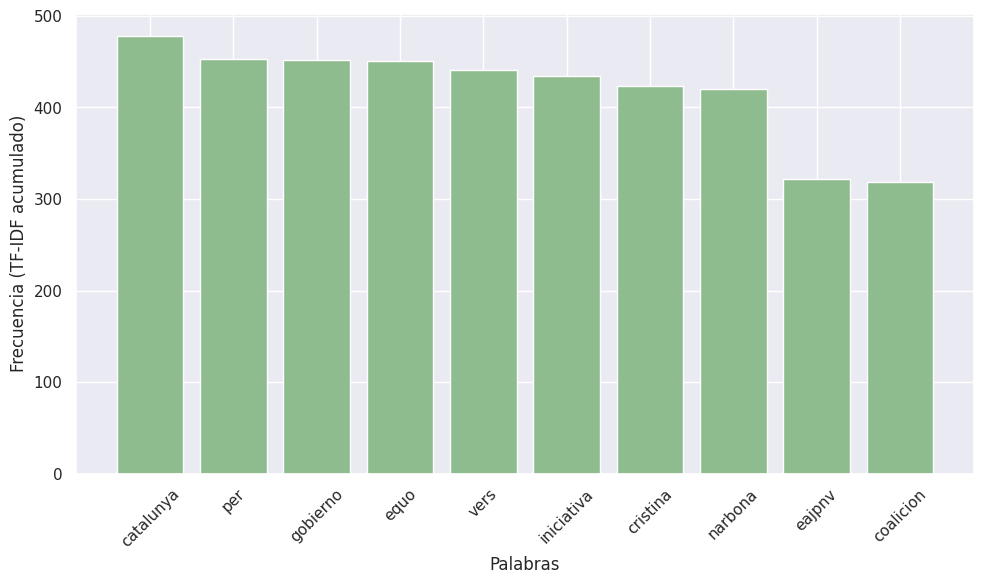

Palabras más comunes en el título de noticias falsas
 


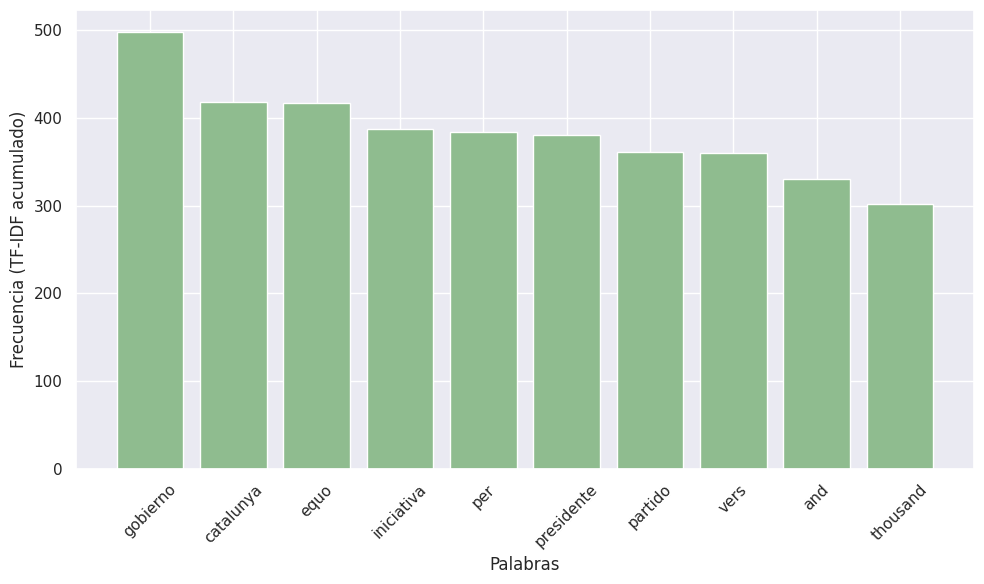

Palabras más comunes en la descripción de noticias falsas
 


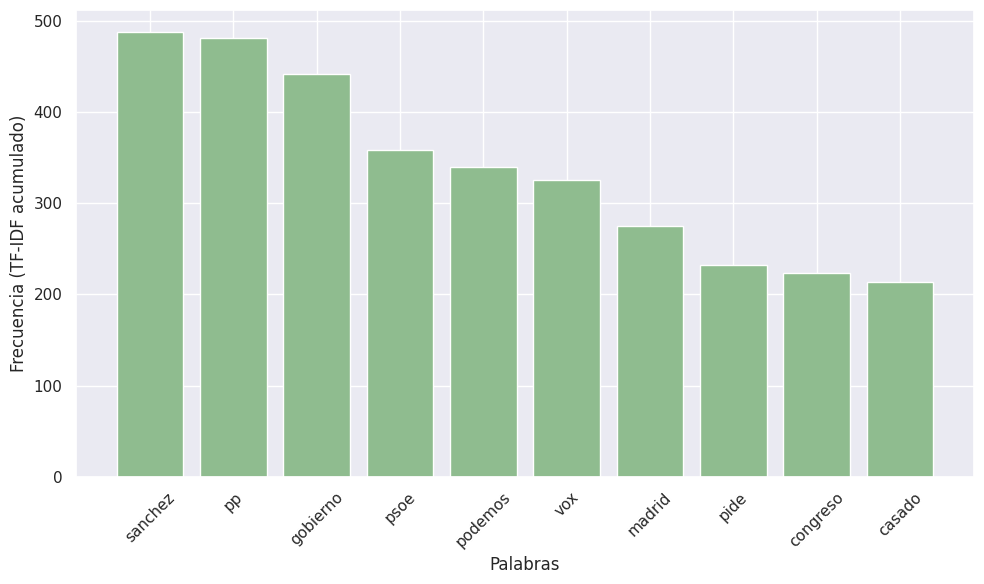

Palabras más comunes en el título de noticias reales
 


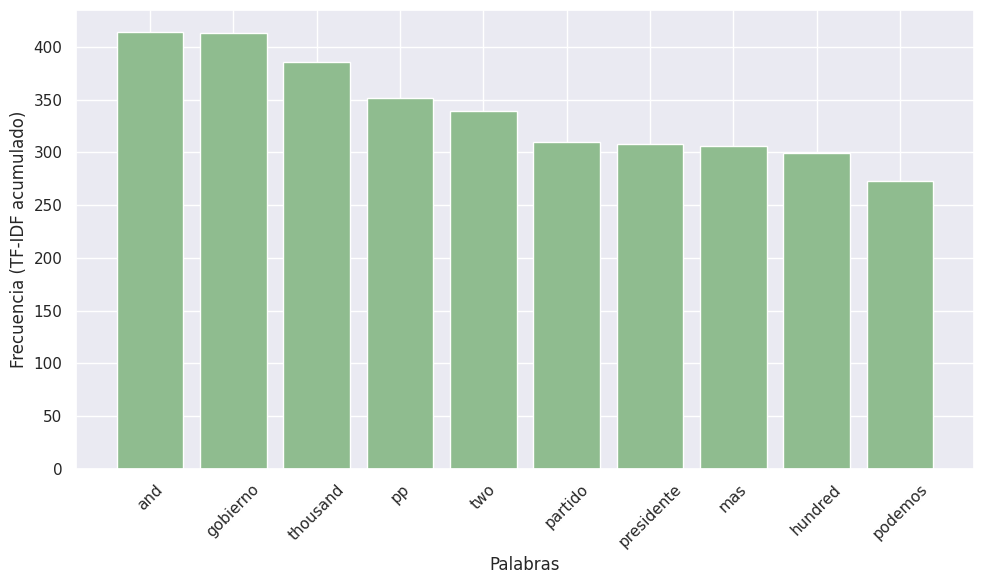

Palabras más comunes en la descripción de noticias reales
 


In [60]:
def mostrar_palabras_comunes(texto, vectorizer, n=10):
    texto_lista = texto.dropna().tolist()
    X = vectorizer.transform(texto_lista)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    df = pd.DataFrame(words_freq[:n], columns=['Palabra', 'Frecuencia'])

    plt.figure(figsize=(10, 6))
    plt.bar(df['Palabra'], df['Frecuencia'], color='#8FBC8F')  # Verde suave
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia (TF-IDF acumulado)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return ""

vectorizer = TfidfVectorizer(max_features=7600)
vectorizer.fit(df['titulo-words'].dropna().tolist() + df['descripcion-words'].dropna().tolist())

textos_falsos_titulos = df[df['Label'] == 0]['titulo-words']
textos_falsos_descripciones = df[df['Label'] == 0]['descripcion-words']
textos_verdaderos_titulos = df[df['Label'] == 1]['titulo-words']
textos_verdaderos_descripciones = df[df['Label'] == 1]['descripcion-words']

print("Palabras más comunes en el título de noticias falsas\n", mostrar_palabras_comunes(textos_falsos_titulos, vectorizer))
print("Palabras más comunes en la descripción de noticias falsas\n", mostrar_palabras_comunes(textos_falsos_descripciones, vectorizer))
print("Palabras más comunes en el título de noticias reales\n", mostrar_palabras_comunes(textos_verdaderos_titulos, vectorizer))
print("Palabras más comunes en la descripción de noticias reales\n", mostrar_palabras_comunes(textos_verdaderos_descripciones, vectorizer))

En los gráficos generados, se observa que en las noticias falsas predominan palabras como "gobierno", "catalunya", "iniciativa", "coalición", "equo" y "bng", mientras que en las noticias verdaderas destacan términos como "gobierno", "pp", "sánchez", "psoe", "vox" y "podemos". Con esto vemos o que ambas categorías de noticias contienen una alta carga política, pero las noticias falsas tienden a incluir nombres de partidos menos convencionales o términos que apelan a narrativas de polarización (discursos que enfatizan divisiones entre grupos sociales, políticos o ideológicos).

# Conclusiones para los usuarios beneficiados

La utilidad de este análisis para la organización radica en su capacidad para fortalecer la detección y filtrado automático de noticias falsas. Al identificar palabras clave recurrentes en este tipo de contenido, se pueden optimizar los algoritmos de clasificación en **Machine Learning**, incorporando estos términos como características para mejorar la precisión del modelo.

 Además, esto permitiría facilitar el **análisis de tendencias**, permitiendo a los beneficiaros detectar y anticipar campañas de desinformación antes de su masificación.

En cuanto al modelo desarrollado, dadas las métricas observadas, con una precisión, recall y F1-Score del 92% para ambas clases, considero que este modelo es adecuado para su implementación en la detección de noticias falsas en un entorno real. Su capacidad de lograr un equilibrio sólido entre precisión y recall permite identificar correctamente la mayoría de las noticias, **aunque no garantiza una detección perfecta.** Aun así, puede servir como una herramienta efectiva en la automatización del filtrado de noticias, complementada con otras estrategias de verificación humana o análisis adicional para minimizar el riesgo de desinformación.